# Trainer

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [4]:
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

### Data

In [5]:
CSV_FILE = "../data/data.csv"

df = pd.read_csv(CSV_FILE)
df[:3]

,t,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,...,tx16,tx17,tx18,tx19,tx20,tx21,tx22,tx23,tx24,tx25
0,1.667897e+12,750.02,598.52,94.50,-55.0,-62.0,-67.0,-63.0,-66.0,-69.0,...,-74.0,-72.0,-70.0,-69.0,-68.0,-67.0,-57.0,-53.0,-73.0,-61.0
1,1.667897e+12,759.46,579.46,94.11,-55.0,-63.0,-67.0,-63.0,-66.0,-68.0,...,-77.0,-72.0,-66.0,-71.0,-57.0,-68.0,-62.0,-56.0,-74.0,-62.0
2,1.667897e+12,770.00,559.05,94.94,-56.0,-62.0,-60.0,-62.0,-58.0,-48.0,...,-74.0,-71.0,-47.0,-70.0,-60.0,-65.0,-61.0,-51.0,-73.0,-62.0


In [6]:
len(df)

16936

### Data Preprocessing

#### Replace -255 to nan

In [7]:
df = df.replace(-255.0, np.nan)

#### Convert RSSI to Radiance

* improve linearity in dataset?

In [8]:
def Watt2DecibelWatt(w):
    return 10 * np.log10(w);

def DecibelWatt2Watt(dB):
    return np.power(10, dB * 0.1)

In [9]:
def convert_rssi_to_radiance(df):
    rad_df = df.copy()
    for col in list(rad_df.columns)[4:]:
        rad_df[col] = rad_df[col].map(DecibelWatt2Watt, na_action='ignore')
    return rad_df
# rad_df = convert_rssi_to_radiance(df)
rad_df = df.copy()
rad_df[:3]

,t,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,...,tx16,tx17,tx18,tx19,tx20,tx21,tx22,tx23,tx24,tx25
0,1.667897e+12,750.02,598.52,94.50,-55.0,-62.0,-67.0,-63.0,-66.0,-69.0,...,-74.0,-72.0,-70.0,-69.0,-68.0,-67.0,-57.0,-53.0,-73.0,-61.0
1,1.667897e+12,759.46,579.46,94.11,-55.0,-63.0,-67.0,-63.0,-66.0,-68.0,...,-77.0,-72.0,-66.0,-71.0,-57.0,-68.0,-62.0,-56.0,-74.0,-62.0
2,1.667897e+12,770.00,559.05,94.94,-56.0,-62.0,-60.0,-62.0,-58.0,-48.0,...,-74.0,-71.0,-47.0,-70.0,-60.0,-65.0,-61.0,-51.0,-73.0,-62.0


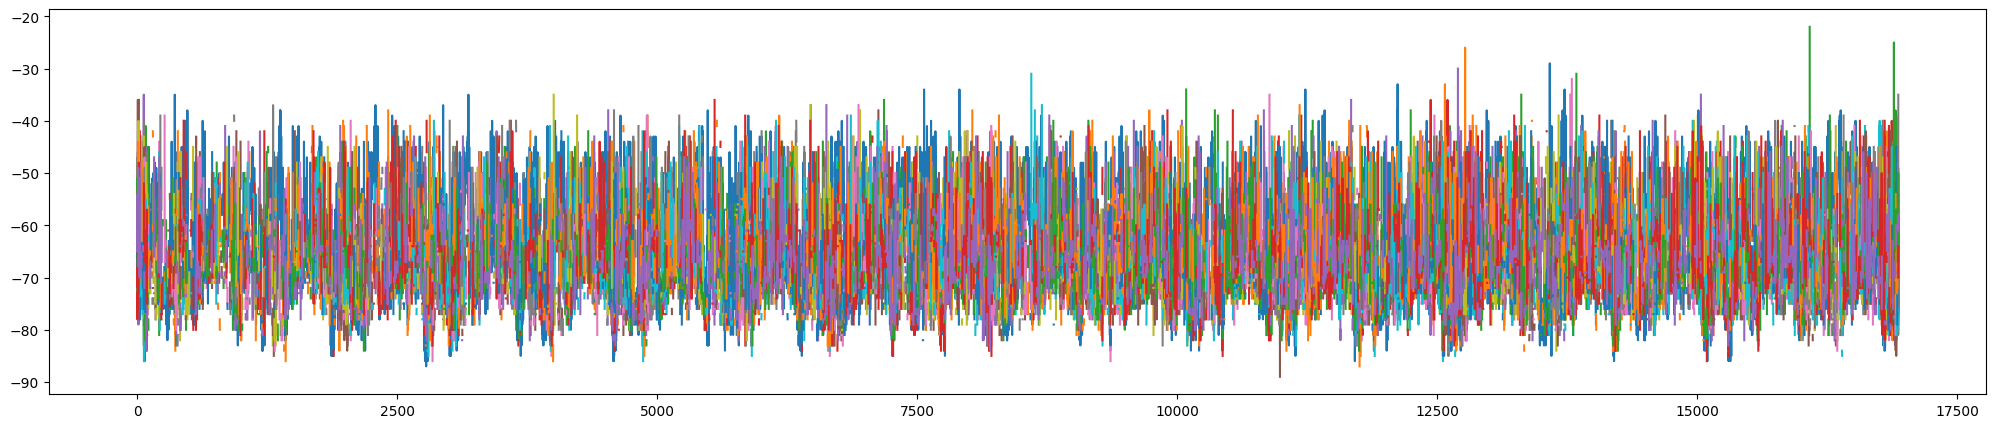

In [10]:
def prep_data(df):
    raw_df = df.copy()
    # keep all 'tx'
    input_df = raw_df[list(df.columns)[4:]].astype('float')
    # only keep 'x','y'
    label_df = raw_df[['x','y','z']]

    plt.figure(figsize=(25,5))
    plt.plot(input_df)
    plt.show()
    
    # concat label with input as new df
    new_df = pd.concat([label_df, input_df], axis=1)
    # get the diff of each rows
    # diff_df = new_df.diff(axis=0)[1:]
    # normalize
    norm_df = (new_df-new_df.mean())/(new_df.std() + 1e-10)
    norm_df = norm_df.interpolate('linear')
    norm_df = norm_df.dropna().reset_index(drop=True)

    return norm_df, new_df
norm_df, new_df = prep_data(df)

In [11]:
new_df.mean()

x      -39.316652
y      -13.787049
z       98.345870
tx1    -64.375457
tx2    -65.736115
tx3    -65.616485
tx4    -65.737063
tx5    -65.142829
tx6    -67.498841
tx7    -64.320284
tx8    -65.573072
tx9    -64.893827
tx10   -66.710230
tx11   -67.934707
tx12   -67.598635
tx13   -67.106566
tx14   -65.014421
tx15   -67.157277
tx16   -67.521792
tx17   -67.437155
tx18   -66.520213
tx19   -67.890968
tx20   -67.473739
tx21   -67.568065
tx22   -65.634427
tx23   -67.719040
tx24   -67.958603
tx25   -67.598895
dtype: float64

In [12]:
new_df.std()

x       525.483493
y       519.459887
z         2.805543
tx1       8.787150
tx2       8.104044
tx3       7.660062
tx4       8.149948
tx5       7.979981
tx6       6.908596
tx7       8.382000
tx8       7.831425
tx9       8.355366
tx10      8.121311
tx11      6.982794
tx12      7.993083
tx13      7.209989
tx14      7.801723
tx15      7.148225
tx16      7.746548
tx17      7.604222
tx18      8.366849
tx19      7.016498
tx20      7.598347
tx21      7.060196
tx22      8.117275
tx23      7.044611
tx24      7.638112
tx25      7.167694
dtype: float64

In [11]:
norm_df[:1]

,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,tx7,...,tx16,tx17,tx18,tx19,tx20,tx21,tx22,tx23,tx24,tx25
0,1.502115,1.178738,-1.370811,1.066951,0.461019,-0.180614,0.335838,-0.107415,-0.217289,-0.319699,...,-0.83627,-0.600041,-0.415902,-0.158061,-0.06926,0.08046,1.06371,2.089404,-0.660032,0.920644


### Create Dataset

In [12]:
columns = list(norm_df)

datagen = DatasetGenerator(data=norm_df,input_width=50,label_width=50,shift=0,columns=list(norm_df),input_columns=columns[3:],
                           label_columns=columns[:3],batch_size=32,partition=(0.8, 0.1, 0.1))

In [13]:
CHECKPOINT_PATH = "../checkpoints/deepar"
HISTORY_PATH = "../checkpoints/deepar/history.csv"
EPOCHS = 100 # epochs on each train() call

In [14]:
class Trainer():
    """
    Trainer -- given dataset and train a model
    """
    def __init__(self, datagen):
        self.dataset_generator = datagen
        self.history = []
    
    def create_checkpoint_manager(self, model):
        ckpt = tf.train.Checkpoint(model=model)
        ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=200)
        return ckpt, ckpt_manager
    
    def train(self):
        dimx = len(self.dataset_generator.input_columns)
        dimz = len(self.dataset_generator.label_columns)
        model = create_model(dim_x=dimx, dim_z=dimz)
        # restore checkpoints if exist
        ckpt, ckpt_manager = self.create_checkpoint_manager(model)
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
        # start training model
        train_result, test_result = {}, {}
        train_ds = self.dataset_generator.train_ds
        test_ds = self.dataset_generator.test_ds
        for i in range(EPOCHS):
            start = time.time()
            for data in train_ds:
                train_result = model.train_step(data)

            for data in test_ds:
                test_result = model.test_step(data)
            template = 'Epoch {}, Loss: {:.5f}, RMSE {:.5f}, Test Loss: {:.5f}, Test RMSE {:.5f}, ETC {:.5f} secs'
            print(template.format(i + 1,
                                  train_result['loss'],
                                  train_result['rmse'],
                                  test_result['loss'],
                                  test_result['rmse'],
                                  time.time() - start))
            self.log_history(training_loss=train_result['loss'],
                             training_rmse=train_result['rmse'],
                             test_loss=test_result['loss'],
                             test_rmse=test_result['rmse'])
            # save model parameters
            print('Saving checkpoint for epoch {} at {}'.format(1, ckpt_manager.save()))
            
    def log_history(self, training_loss, training_rmse, test_loss, test_rmse):
        self.history.append([training_loss, training_rmse, test_loss, test_rmse])
        np.savetxt(fname=HISTORY_PATH,
                   X=self.history,delimiter=",",
                   header='training_loss,training_rmse,test_loss,test_rmse',
                   fmt='%f',
                   comments='')

In [15]:
trainer = Trainer(datagen)
trainer.train()

Epoch 1, Loss: 5.24567, RMSE 0.64433, Test Loss: 5.25443, Test RMSE 0.63857, ETC 88.23634 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-1
Epoch 2, Loss: 5.07605, RMSE 0.61446, Test Loss: 5.09897, Test RMSE 0.61283, ETC 85.26065 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-2
Epoch 3, Loss: 4.99041, RMSE 0.60367, Test Loss: 4.98148, Test RMSE 0.60289, ETC 88.74808 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-3
Epoch 4, Loss: 4.96769, RMSE 0.59798, Test Loss: 4.90949, Test RMSE 0.59751, ETC 99.29048 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-4
Epoch 5, Loss: 4.87433, RMSE 0.59443, Test Loss: 4.86048, Test RMSE 0.59413, ETC 91.64810 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-5
Epoch 6, Loss: 4.86074, RMSE 0.59201, Test Loss: 4.81142, Test RMSE 0.59179, ETC 85.61126 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-6
Epoch 7, Loss: 4.83855, RMSE 0.59024, Test Loss: 4.76707, 

### Evaluation

In [16]:
from preprocess.data_generator import WindowSplitter


In [17]:
full_datagen = DatasetGenerator(data=norm_df,
                                input_width=1000,
                                label_width=1000,
                                shift=0,
                                columns=list(norm_df),
                                input_columns=columns[3:],
                                label_columns=columns[:3],
                                batch_size=1,
                                partition=(1, 0, 0))

In [18]:
def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    plt.figure(figsize=(20,10))
    inputs, labels = data
    means, _ = model(inputs[:,:,:])
    mean = (means[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    label = (labels[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    
    # as a velocity value we need to performance .cumsum(), to convert it back to the change of position
    # plt.plot(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, '-r', alpha=0.5)
    
    plt.scatter(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, s=30, marker='x', alpha=1)
    plt.scatter(label[warmup_step:,0].numpy() + x_offset, label[warmup_step:,1].numpy() + y_offset, s=30, marker='.', alpha=1)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [19]:
def restore_model():
    model = create_model(dim_x=len(columns[3:]), dim_z=3)
    # restore checkpoints if exist
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
    return model

In [20]:
model = restore_model()

Restoring checkpoint from ../checkpoints/deepar\ckpt-100


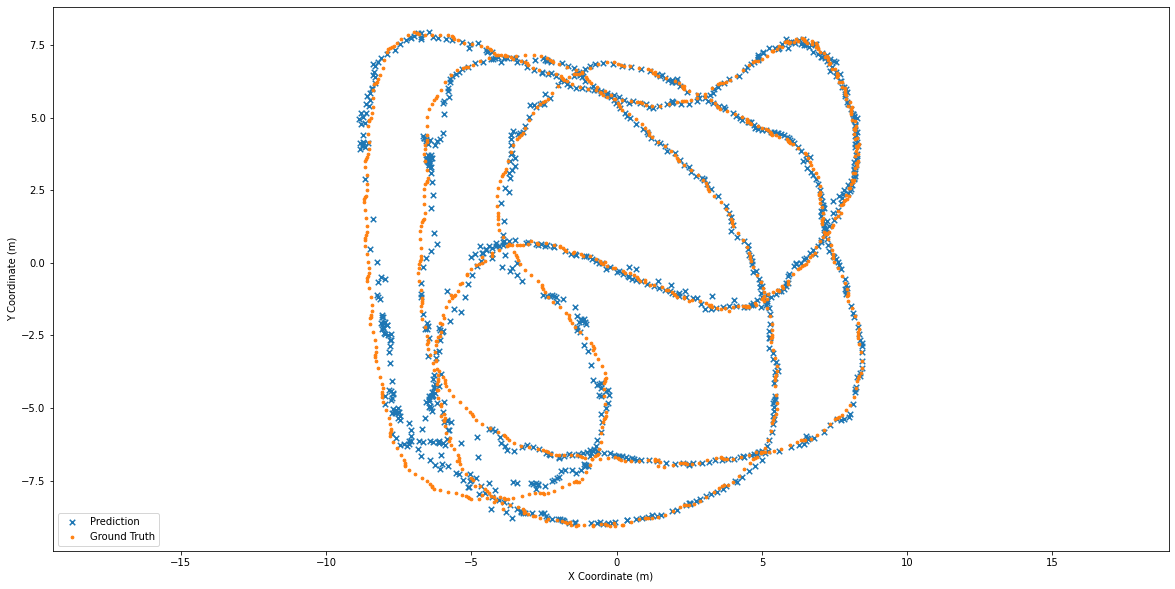

In [25]:
example = next(iter(full_datagen.train_ds))
model_plot2D(model, example, 0, df_mean=new_df.mean()[:3], df_std=new_df.std()[:3] + 1e-10) # [:3] is label columns x,y,z